In [1]:
import starepandas
import geopandas
import pickle
import pystare
import matplotlib.pyplot as plt
import datetime
import numpy

In [24]:
# We set level to 15 because that appears to be matching VNP02 nadir resolution 
level = 15

In [25]:
caribbean = geopandas.read_file('study_area_fao_clean_210326.gpkg')

In [26]:
caribbean = starepandas.STAREDataFrame(caribbean, add_stare=True, level=level, add_trixels=True, n_workers=60)

fname = 'covers/caribbean_staredf_l{}.pickle'.format(level)
with open(fname, 'wb') as f:
    pickle.dump(caribbean, f)

In [27]:
# Or load it from pickle
fname = 'covers/caribbean_staredf_l{}.pickle'.format(level)
with open(fname, 'rb') as f:
    caribbean = pickle.load(f)

In [28]:
sids = list(caribbean['stare'])
numpy.concatenate(sids).size

3038344

<AxesSubplot:>

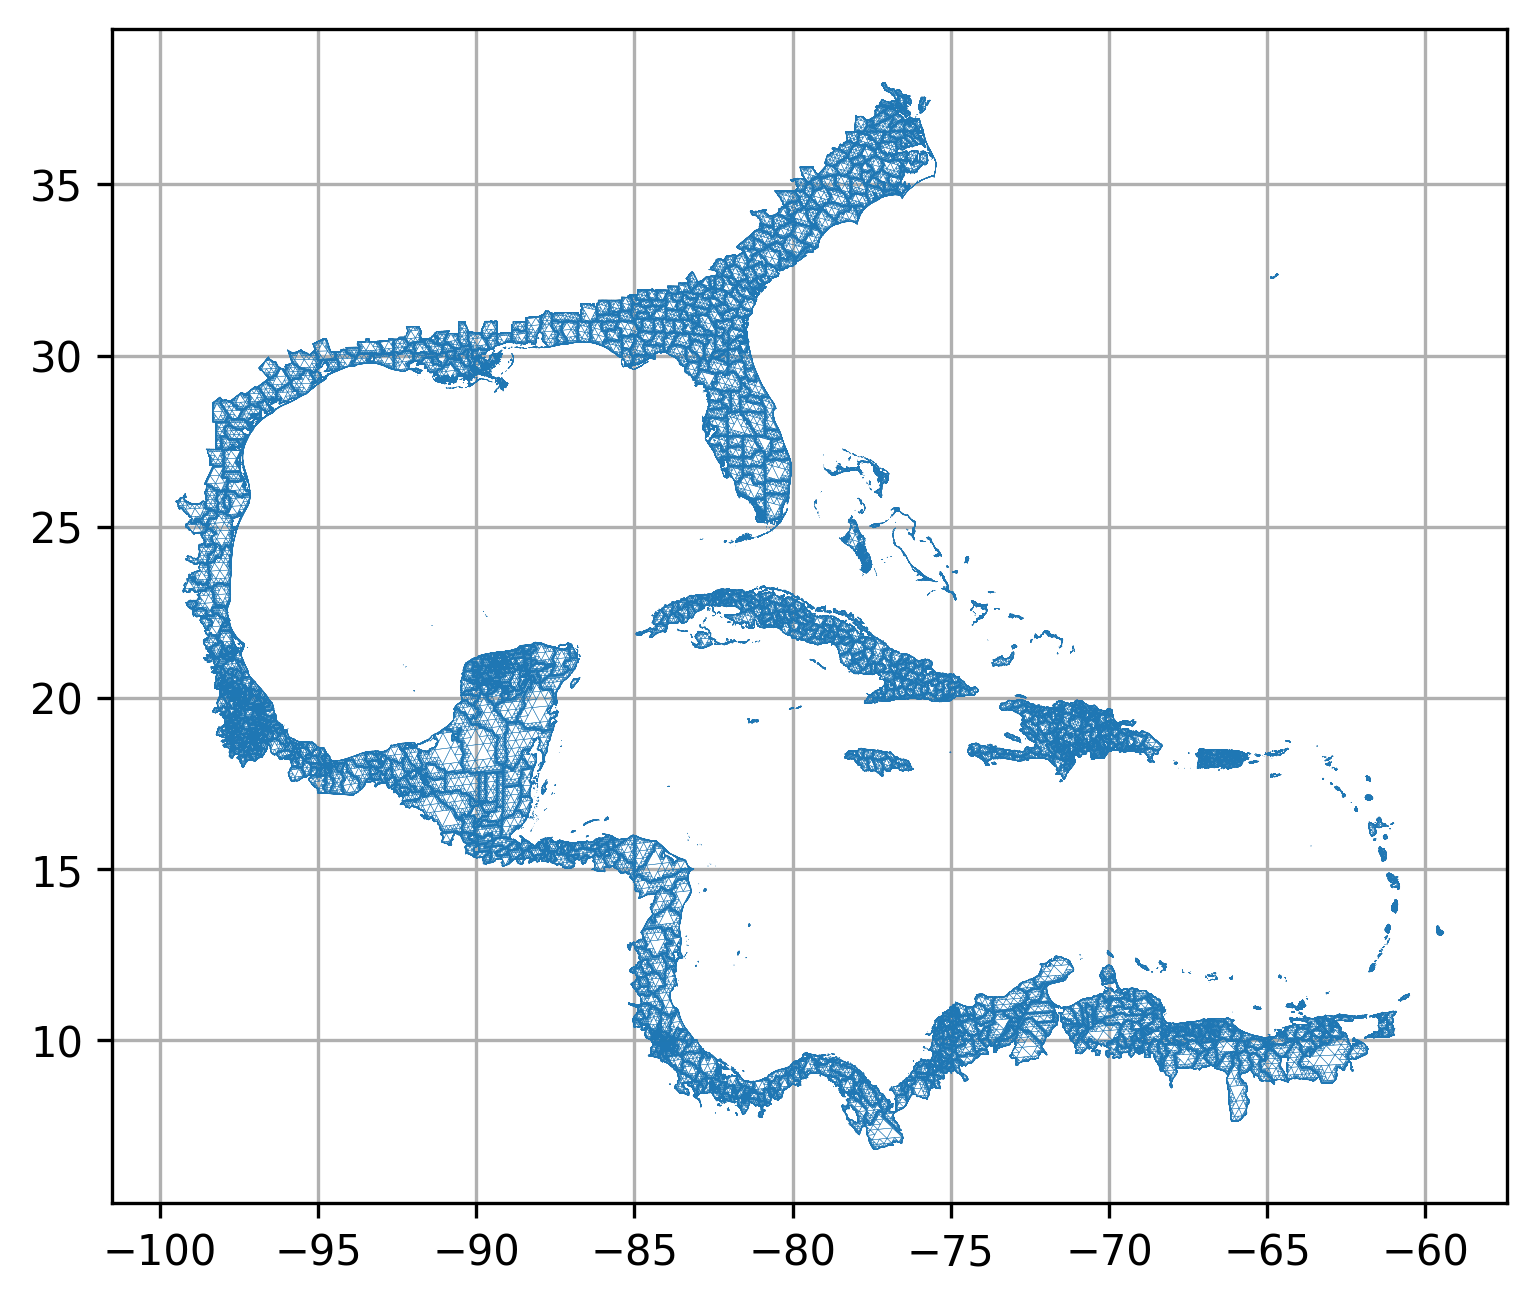

In [29]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax.grid(True)

caribbean.plot(ax=ax, trixels=True, boundary=True, linewidth=0.1)

# STARE Cover for the whole ROI

In [30]:
start = datetime.datetime.now()
cover_sids = caribbean.stare_dissolve(n_workers=10)
print(datetime.datetime.now() - start)

0:52:53.717247


In [31]:
fname = 'covers/caribbean_sids_cover_l{}.pickle'.format(level)
with open(fname, 'wb') as f:
    pickle.dump(cover_sids, f)

In [32]:
#fname = 'covers/caribbean_sids_cover_l{}.pickle'.format(level)
with open(fname, 'rb') as f:
    cover_sids = pickle.load(f)

# Making countrywise DF

## STARE Dissolve

In [33]:
start = datetime.datetime.now()
countries = caribbean.stare_dissolve(by='ADM0_CODE', geom=False, n_workers=20)
trixels = countries.trixels(n_workers=10)
countries.set_trixels(trixels, inplace=True)
print(datetime.datetime.now() - start)

0:19:09.879082


In [34]:
fname = 'covers/countries_staredf_l{}.pickle'.format(level)
with open(fname, 'wb') as f:
    pickle.dump(countries, f)

## Simplify -> Dissolve -> STARE lookup

In [14]:
geom_simple = caribbean.simplify(0.001, preserve_topology=True)
caribbean['geom_simple'] = geom_simple

n_geom = 0
n_simple = 0

for index, row in caribbean.iterrows():
    for p in row.geometry:
        n_geom += len(p.exterior.coords)    
        
    if row.geom_simple.geom_type =='Polygon':
        n_simple += len(row.geom_simple.exterior.coords)
    else:
        for p in row.geom_simple:
            n_simple += len(p.exterior.coords)

print(n_geom)
print(n_simple)

3690977
476278


In [15]:
caribbean.set_geometry('geom_simple', inplace=True)

<AxesSubplot:>

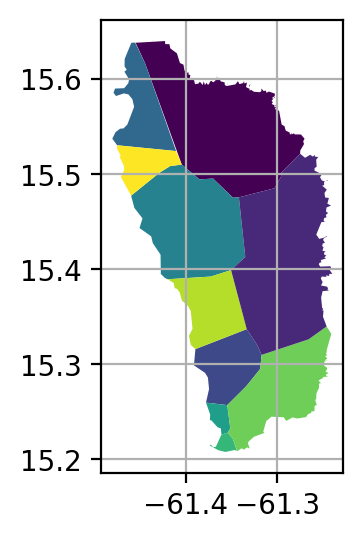

In [16]:
# Just to verify if simplification is OK
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

country = caribbean[caribbean.ADM0_NAME=='Dominica']
country.plot(ax=ax, column='ADM1_CODE')

In [17]:
# Option a
start = datetime.datetime.now()
countries1 = caribbean.dissolve(by='ADM0_CODE')
countries1 = starepandas.STAREDataFrame(countries1, add_stare=True, level=level, add_trixels=True, n_workers=20)
print(datetime.datetime.now() - start)

0:43:54.143410


In [18]:
# Option b
start = datetime.datetime.now()
countries2 = caribbean.stare_dissolve(by='ADM0_CODE', geom=False, n_workers=20)
trixels = countries2.trixels(n_workers=20)
countries2.set_trixels(trixels, inplace=True)
print(datetime.datetime.now() - start)

0:17:55.186681


In [19]:
# also, dissolve them all 
# Simplified STARE cover

# Simplified STARE cover
start = datetime.datetime.now()
cover_sids = countries2.stare_dissolve(n_workers=10)
print(datetime.datetime.now() - start)
print(len(cover_sids))

0:42:22.042709
404129


<AxesSubplot:>

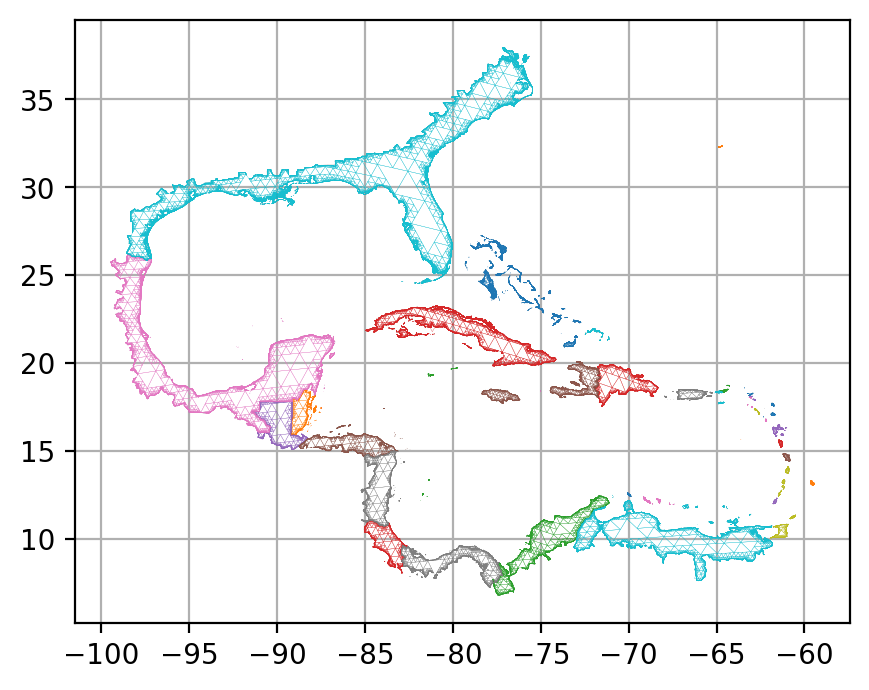

In [20]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.grid(True)

countries1.plot(ax=ax, trixels=True, column='ADM0_NAME', linewidth=0.1)

<AxesSubplot:>

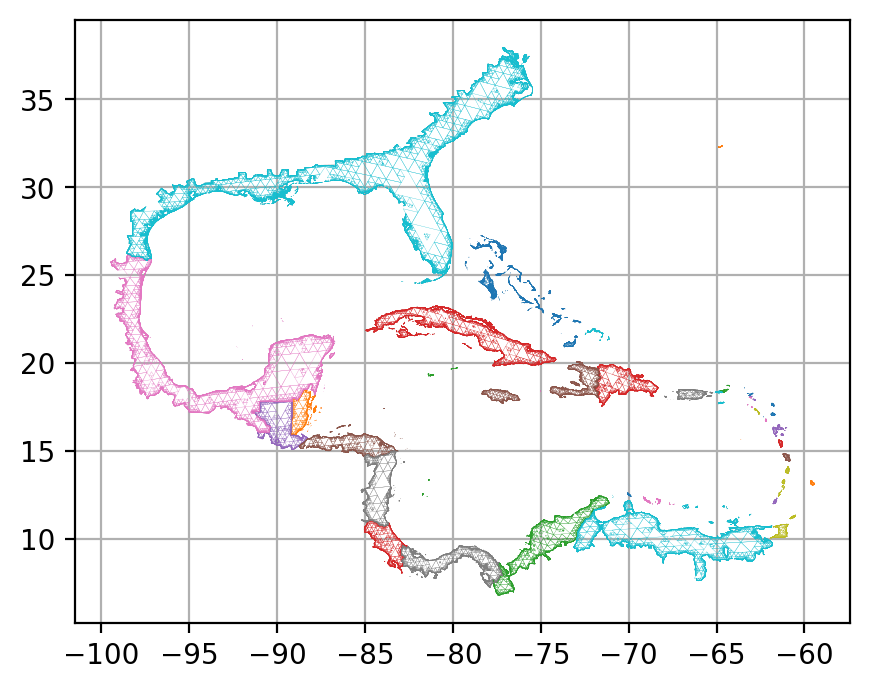

In [21]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.grid(True)

countries2.plot(ax=ax, trixels=True, column='ADM0_NAME', linewidth=0.1)

In [22]:
# Simplified STARE cover
start = datetime.datetime.now()
cover_sids = countries1.stare_dissolve(n_workers=10)
print(datetime.datetime.now() - start)
print(len(cover_sids))

0:44:41.068542
396666
